In [263]:
# import
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [264]:
# read dataset
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df = pd.read_csv(f).fillna(0)

# convert non-timeseries
df[['City', 'State', 'Metro', 'CountyName']] = df[['City', 'State', 'Metro', 'CountyName']].astype(str)
df[['RegionID', 'RegionName', 'SizeRank']] = df[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df[['City', 'State', 'Metro', 'CountyName']] = df[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower()
)

# timeseries data
ts_index = df.columns.get_loc('1996-04') + 1
date_columns = df.iloc[:, ts_index:len(df.columns)].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

In [265]:
# metro areas
hot_springs = df.loc[(df['Metro'] == 'hot springs') & (df['State'] == 'ar')]
little_rock = df.loc[(df['Metro'] == 'little rock') & (df['State'] == 'ar')]
fayetteville = df.loc[(df['Metro'] == 'fayetteville') & (df['State'] == 'ar')]
searcy = df.loc[(df['Metro'] == 'searcy') & (df['State'] == 'ar')]

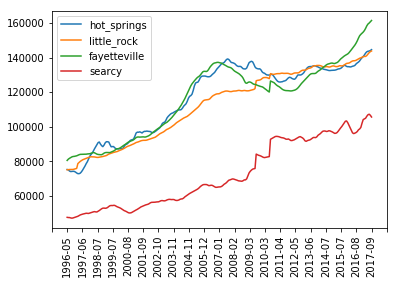

In [266]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()

In [288]:
# train: collapse column by median
train_start = df.columns.get_loc('1997-01')
train_stop = df.columns.get_loc('2017-01')
train_columns = df.iloc[:, train_start:train_stop].columns.tolist()
test_columns = df.iloc[:, (train_stop + 1):len(df.columns)].columns.tolist()

#
# transpose dataframe: left column data, right column value
#
#     date1  val1
#     date2  val2
#      ...   ...
#     daten  valn
#
df_train = df[train_columns].median().T
df_test = df[test_columns].median().T

#
# build arima model:
#
#     AR: autoregression, uses observations from previous time steps as input to
#         a regression equation to predict the value at the next time step.
#
#     I: integrated, use of differencing of raw observations, or subtracting an
#         observation from previous time step. The goal is to attain a time
#         series that is stationary.
#
#     MA: moving average, uses the dependency between an observation and a residual
#         error from a moving average model applied to lagged observations.
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1798.402
Method:                       css-mle   S.D. of innovations            447.013
Date:                Sat, 10 Nov 2018   AIC                           3610.803
Time:                        15:46:07   BIC                           3635.139
Sample:                    02-01-1997   HQIC                          3620.610
                         - 12-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        534.2338    271.607      1.967      0.050       1.894    1066.574
ar.L1.D.y      0.2938      0.070      4.188      0.000       0.156       0.431
ar.L2.D.y      0.1015      0.072      1.413      0.1

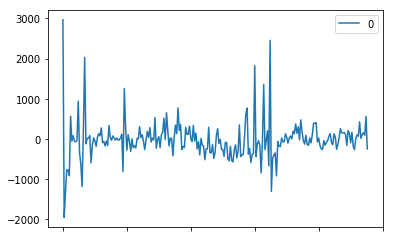

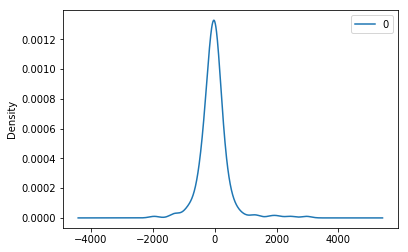

In [268]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# plot kernel density estimation
residuals.plot(kind='kde')
plt.show()

In [269]:
# descriptive statistics on residual
print(residuals.describe())

                 0
count   239.000000
mean    -19.418311
std     476.931209
min   -1952.020377
25%    -216.379550
50%     -30.589957
75%     116.981119
max    2965.766158


In [314]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 19

for t in range(iterations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    try:
        obs = df_test[t]
        history.append(obs)
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        print('predicted={:03f}'.format(float(yhat)))

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra


date: 2017-2
-----------------------------------------------
predicted=177232.983241, expected=178300.000000
prediction difference: 0.005984

predicted=177232.983241

date: 2017-3
-----------------------------------------------
predicted=179481.594017, expected=179200.000000
prediction difference: 0.001571

predicted=179481.594017

date: 2017-4
-----------------------------------------------
predicted=180263.156192, expected=179900.000000
prediction difference: 0.002019

predicted=180263.156192

date: 2017-5
-----------------------------------------------
predicted=180888.140435, expected=180600.000000
prediction difference: 0.001595

predicted=180888.140435

date: 2017-6
-----------------------------------------------
predicted=181520.268499, expected=181300.000000
prediction difference: 0.001215

predicted=181520.268499

date: 2017-7
-----------------------------------------------
predicted=182290.950278, expected=182000.000000
prediction difference: 0.001599

predicted=182290.95027

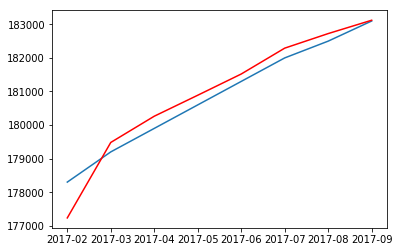

In [284]:
# plot rolling prediction
plt.plot(df_test)
plt.plot(predictions, color='red')
plt.show()

In [302]:
forecast = model_fit.predict(start='2018-01', end='2018-12')

KeyError: "invalid literal for int() with base 10: '2018-01'"